In [41]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import stan_jupyter as stan
import pandas as pd

import sys         

sys.path.append('../../disty')        
from disty import Posterior, DataTools
dt = DataTools()

In [23]:
df = pd.read_csv("sim_data.csv")

## Speed test: standardized, logged, normal

## Poisson vs. negative binomial vs. normal

## Using matrices for covariates 

## Standardizing by group

In [24]:
dt.standardize(df, ["quantity", "price", "competitor_price"], ["sku", "account"])
dt.center(df, ["quantity", "price", "competitor_price"], ["sku", "account"])
dt.log(df, ["quantity", "price", "competitor_price"])

In [25]:
df

,sku,account,price,competitor_price,quantity,std_quantity,std_price,std_competitor_price,ctr_quantity,ctr_price,ctr_competitor_price,log_quantity,log_price,log_competitor_price
0,1,1,56.823414,42.491756,37,-0.091703,-1.037799,0.909556,-0.53,-7.003338,3.701783,3.610945,4.039966,3.749334
1,1,1,65.407358,37.075356,35,-0.437751,0.234224,-0.421294,-2.53,1.580606,-1.714617,3.555377,4.180650,3.612979
2,1,1,58.050157,36.086574,42,0.773417,-0.856012,-0.664245,4.47,-5.776595,-2.703398,3.737693,4.061325,3.585949
3,1,1,64.869742,36.131272,39,0.254345,0.154557,-0.653263,1.47,1.042990,-2.658700,3.663587,4.172397,3.587186
4,1,1,57.048158,42.046096,35,-0.437751,-1.004495,0.800054,-2.53,-6.778594,3.256123,3.555377,4.043913,3.738790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,5,5,145.665569,165.042661,34,-0.286693,-0.077608,-0.810509,-2.52,-1.389133,-14.787764,3.526390,4.981320,5.106210
2496,5,5,155.103174,194.590884,36,-0.059159,0.449650,0.809012,-0.52,8.048472,14.760459,3.583547,5.044097,5.270904
2497,5,5,151.931073,176.497027,29,-0.855528,0.272432,-0.182702,-7.52,4.876372,-3.333399,3.367330,5.023434,5.173310
2498,5,5,146.788845,227.713877,53,1.874881,-0.014853,2.624464,16.48,-0.265857,47.883452,3.970311,4.989002,5.428094


In [26]:
group_counts = [3, 10]
group_cols = ["one", "two"]

for i in range(len(group_cols)):
    print(group_cols[i], group_counts[i])

one 3
two 10


In [27]:
with open("stan_code/base_case_prior_predictive_check.stan", "r") as f:
    model_code = f.read()
    
model_data = {
    "N":len(df),
    "N_SKUS":df.sku.nunique(),
    "N_ACCOUNTS":df.account.nunique(),
    "sku":df.sku.tolist(),
    "account":df.account.tolist(),
    "quantity":df.quantity.tolist(),
    "price":df.price.tolist(),
    "competitor_price":df.competitor_price.tolist(),
}

In [28]:
%%capture
posterior = stan.build(model_code, model_data)

In [29]:
%%time
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000) # Normal model

CPU times: user 23.3 s, sys: 1.79 s, total: 25.1 s
Wall time: 48.1 s


In [18]:
[k for k in fit]

['alpha', 'beta', 'gamma', 'sigma', 'mu', 'y_pred']

In [76]:
class Posterior:

    def __init__(self, fit):
        self.fit = fit

        for key in fit:
            setattr(self, key, [n for n in self.fit[key][0]])

    def list_params(self):
        return([k for k in self.fit])

    def plot_coef(self, X, y, intercept, coef):

        size = len(coef)
        scale = np.linspace(min(X)-np.mean(X), max(X)-np.mean(X), size)

        plt.figure(figsize=(20, 10))
        plt.plot(X-np.mean(X), y-np.mean(y), "C0o", alpha=.3)
        for i in range(1, size):
            plt.plot(
                scale,
                intercept[i]+coef[i]*scale,
                color='black',
                alpha=.01)
            plt.title("Slope for coefficient")
            plt.xlabel("X value")
            plt.ylabel("Predicted")


In [77]:
test = Posterior(fit)

In [1]:
#test.plot_coef(df.price.tolist(), df.quantity.tolist(), test.alpha, test.beta)

In [63]:
df.quantity.describe()

count    2500.000000
mean       36.474400
std         6.819204
min        15.000000
25%        32.000000
50%        36.000000
75%        41.000000
max        64.000000
Name: quantity, dtype: float64

In [ ]:
plt.figure(figsize=(20,10))
for i in range(1, 10000):
    plt.plot(
        df.price-df.price.mean(),
        sample_alpha[i]+sample_beta[i]*(df.age-df.age.mean()),
        color='black',
        alpha=.01)

In [26]:
scale

0      -43.821961
1      -35.238017
2      -42.595218
3      -35.775633
4      -43.597217
          ...    
2495    45.020194
2496    54.457799
2497    51.285698
2498    46.143470
2499    37.618290
Name: price, Length: 2500, dtype: float64

<AxesSubplot:>

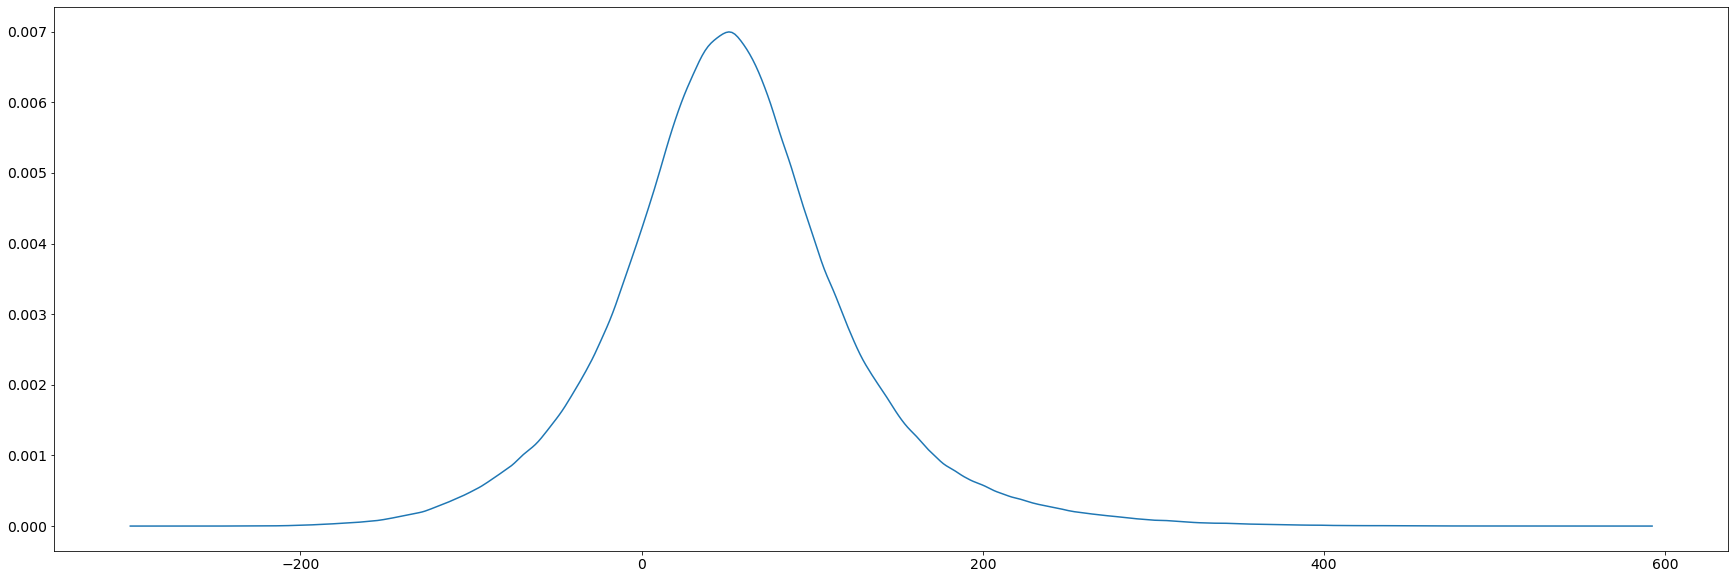

In [231]:
plt.figure(figsize=(30, 10))
az.plot_kde(fit['y_pred'])

In [232]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,52.907,19.213,17.232,91.275,2.140,1.519,82.0,47.0,1.06
beta,-2.142,0.946,-3.650,-0.484,0.121,0.086,48.0,32.0,1.08
gamma,2.184,0.931,0.387,3.842,0.095,0.067,94.0,97.0,1.05
sigma,4.309,2.501,0.232,8.721,0.283,0.201,66.0,155.0,1.06
mu[0],21.305,69.115,-102.815,136.718,6.788,4.813,105.0,194.0,1.02
...,...,...,...,...,...,...,...,...,...
y_pred[2495],98.598,76.830,-65.165,213.313,8.513,6.041,82.0,122.0,1.03
y_pred[2496],143.114,103.609,-63.932,314.927,11.174,7.928,87.0,152.0,1.03
y_pred[2497],110.226,88.313,-63.762,259.266,9.692,6.878,83.0,96.0,1.03
y_pred[2498],233.187,128.115,-2.622,464.295,13.212,9.372,94.0,123.0,1.04


In [ ]:
az.plot_kde(stats.norm.rvs(loc=50, scale=30, size=1000))

In [72]:
%%time
#%%capture
fit = posterior.sample(num_chains=4, num_samples=1000) # Standardized

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   5% (401/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  21% (1700/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  51% (4100/8000)
Sampling:  68% (5400/8000)
Sampling:  70% (5601/8000)
Sampling:  88% (7001/8000)
Sampling:  89% (7100/8000)
Sampling:  90% (7200/8000)
Sampling:  91% (7300/8000)
Sampling:  92% (7400/8000)
Sampling:  94% (7500/8000)
Sampling:  95% (7600/8000)
Sampling:  96% (7700/8000)
Sampling:  98% (7800/8000)
Sampling:  99% (7900/8000)
S

CPU times: user 25.7 s, sys: 1.71 s, total: 27.5 s
Wall time: 49.8 s


<AxesSubplot:>

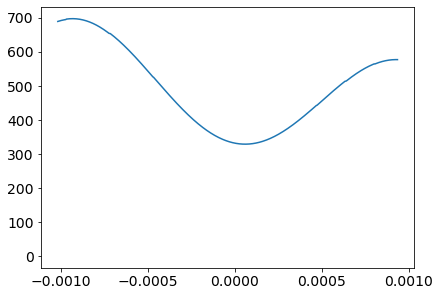

In [162]:
az.plot_kde([n.mean() for n in fit['account_slope']])

<AxesSubplot:>

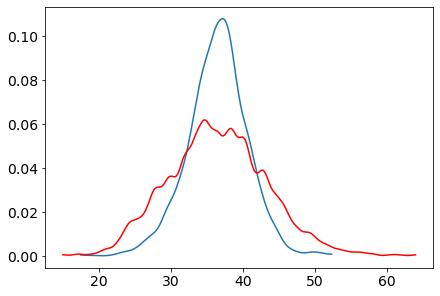

In [161]:
az.plot_kde([n.mean() for n in fit['y_pred']])
az.plot_kde([n.mean() for n in fit['y']], plot_kwargs={"color":'r'})